# Проведение А/В тестирования для крупного интернет-магазина

Вместе с отделом маркетинга подготовили список гипотез для увеличения выручки.\
Приоритизируем гипотезы, запустим A/B-тест и проанализируем результаты.

## Часть 1. Приоритизация гипотез.

Для на чала выгрузим данные с гипотезами и оценками. Ознакомимся с данными и проведем приоритизацию, использую фреймворки ICE и RICE.

In [1]:
import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from pandas.plotting import register_matplotlib_converters
import warnings
# конвертеры, которые позволяют использовать типы pandas в matplotlib  
register_matplotlib_converters()

df = pd.read_csv('C:\\Users\\jmilo\\OneDrive\\Рабочий стол\\Яндекс.Практикум\\Проверка гипотез\\hypothesis.csv')

df

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


In [2]:
# Посчитаем ICE для гипотез
df['ICE'] = round((df.Impact*df.Confidence) / df.Efforts, 1)

display(df[['Hypothesis', 'ICE']].sort_values(by='ICE', ascending=False))

,Hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день...",16.2
0,"Добавить два новых канала привлечения трафика,...",13.3
7,Добавить форму подписки на все основные страни...,11.2
6,Показать на главной странице баннеры с актуаль...,8.0
2,Добавить блоки рекомендаций товаров на сайт ин...,7.0
1,"Запустить собственную службу доставки, что сок...",2.0
5,"Добавить страницу отзывов клиентов о магазине,...",1.3
3,"Изменить структура категорий, что увеличит кон...",1.1
4,"Изменить цвет фона главной страницы, чтобы уве...",1.0


In [3]:
# Посчитаем RICE для гипотез
df['RICE'] = (df.Reach*df.Impact*df.Confidence) / df.Efforts

display(df[['Hypothesis', 'RICE']].sort_values(by='RICE', ascending=False))

,Hypothesis,RICE
7,Добавить форму подписки на все основные страни...,112.0
2,Добавить блоки рекомендаций товаров на сайт ин...,56.0
0,"Добавить два новых канала привлечения трафика,...",40.0
6,Показать на главной странице баннеры с актуаль...,40.0
8,"Запустить акцию, дающую скидку на товар в день...",16.2
3,"Изменить структура категорий, что увеличит кон...",9.0
1,"Запустить собственную службу доставки, что сок...",4.0
5,"Добавить страницу отзывов клиентов о магазине,...",4.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3.0


**При применении RICE вместо ICE гипотеза под номером 8 опустилась с первой строчки на 5. Это связано с тем, что у этой гипотезы наименьший среди всех охват (Reach=1), поэтому ее оценка никак не изменилась.\
Следует обратить внимание на гипотезы с индексом 0 и 7, так как при подсчете ICE они входили в ТОП-3, и после учета оценки охвата также остались в ТОП-3. Гипотеза 7 засчет самого большого охвата и приемлемой стоимости получила в два раза больше баллов, чем ближайшая к ней.**

## Часть 2. Анализ A/B-теста

In [4]:
# Выгрузим данные о визитах и покупках и ознакомимся с ними
orders = pd.read_csv('C:\\Users\\jmilo\\OneDrive\\Рабочий стол\\Яндекс.Практикум\\Проверка гипотез\\orders.csv')

orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [5]:
# Исправим названия столбцов
orders = orders.rename(columns=
                      {
                          'transactionId': 'transaction_id',
                          'visitorId': 'visitor_id'
                      })
orders.head()

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [6]:
# Проверим наличие дубликатов
print('Количество дубликатов:', orders.duplicated().sum())

Количество дубликатов: 0


In [7]:
# Проверим информацию о датафрейме
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   transaction_id  1197 non-null   int64 
 1   visitor_id      1197 non-null   int64 
 2   date            1197 non-null   object
 3   revenue         1197 non-null   int64 
 4   group           1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


Пропусков нет. Необходимо привести столбец date в нужный формат

In [8]:
# Приведем столбец date к формату даты
orders['date'] = orders['date'].astype('datetime64[D]')
orders['date'] = orders['date'].map(lambda x: dt.datetime.strftime(x, '%Y-%m-%d'))
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [9]:
visits = pd.read_csv('C:\\Users\\jmilo\\OneDrive\\Рабочий стол\\Яндекс.Практикум\\Проверка гипотез\\visitors.csv')

visits.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [10]:
# Проверим наличие дубликатов
print('Количество дубликатов:', visits.duplicated().sum())

Количество дубликатов: 0


In [11]:
# Проверим информацию о датафрейме
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


Пропусков нет. Необходимо привести столбец date в нужный формат

In [12]:
# Приведем столбец date к формату даты
visits['date'] = visits['date'].astype('datetime64[D]')
visits['date'] = visits['date'].map(lambda x: dt.datetime.strftime(x, '%Y-%m-%d'))
visits['date'] = visits['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

**Вывод:** выполнили предобработку данных - исправили названия столбцов, проверили дубликаты и пропуски, привели данные к необходимому типу.

**Построим график кумулятивной выручки по группам.**

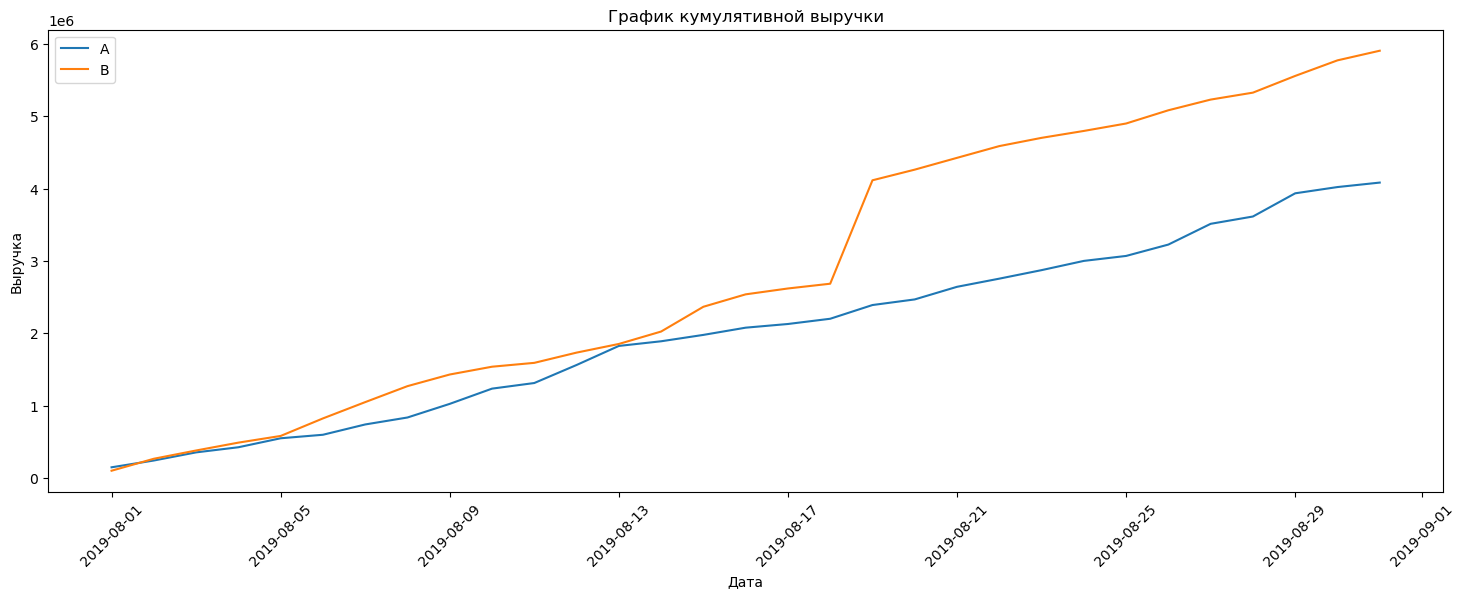

In [13]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date', 'group']].drop_duplicates()
# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])
# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(
    lambda x: visits[
        np.logical_and(
            visits['date'] <= x['date'], visits['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])
# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]
plt.rcParams["figure.figsize"] = (18,6)
# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.title('График кумулятивной выручки')
plt.xticks(rotation=45)
plt.ylabel('Выручка')
plt.xlabel('Дата')
plt.legend();

**Вывод:** сначала обе группы показывали примерно одинаковые результаты, но примерно в середине теста есть резкий рост группы В и последующий рост до конца теста. Это может быть следствием влияния аномально больших заказов (выбросов).

**Построим график кумулятивного среднего чека по группам.**

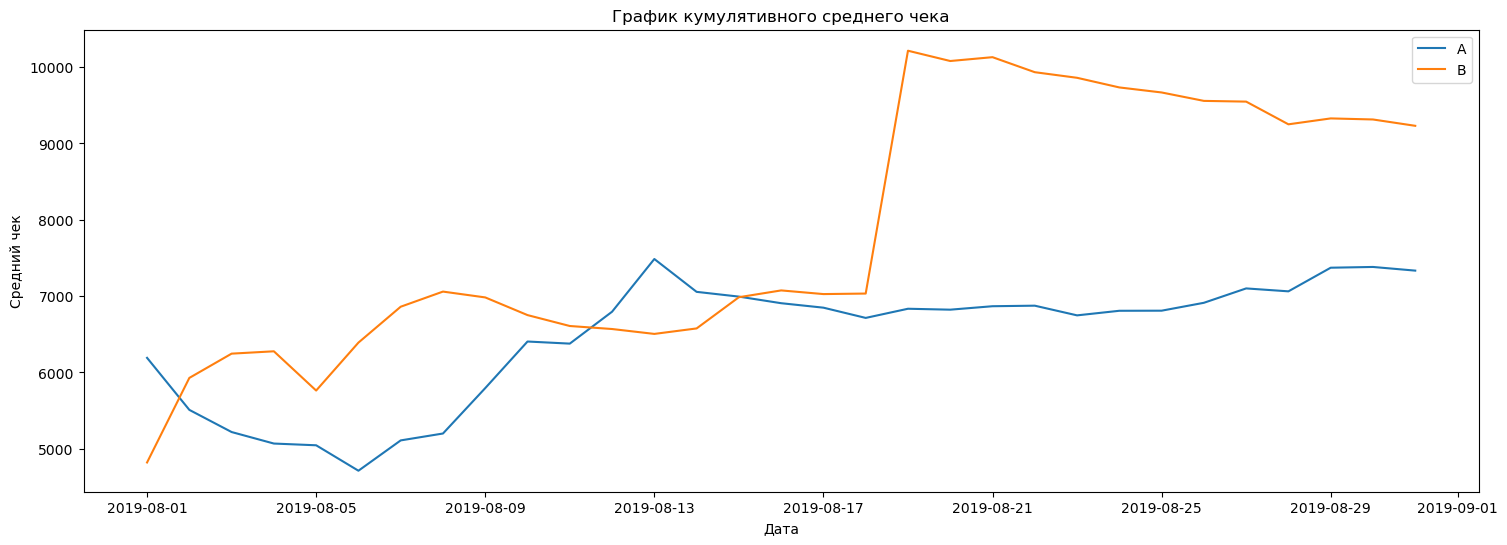

In [14]:
# Построим графики среднего чека по группам — разделим кумулятивную выручку на кумулятивное число заказов
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.title('График кумулятивного среднего чека')
plt.ylabel('Средний чек')
plt.xlabel('Дата')
plt.legend();

**Вывод:** на графике кумулятивного значения среднего чека в группе В виден резкий рост в середине теста. Оба графика имеют колебания в начале, в конце графики стабилизировались. Более точный анализ можно будет провести после "очистки" данных.

**Построим график относительного изменения кумулятивного среднего чека группы B к группе A.**

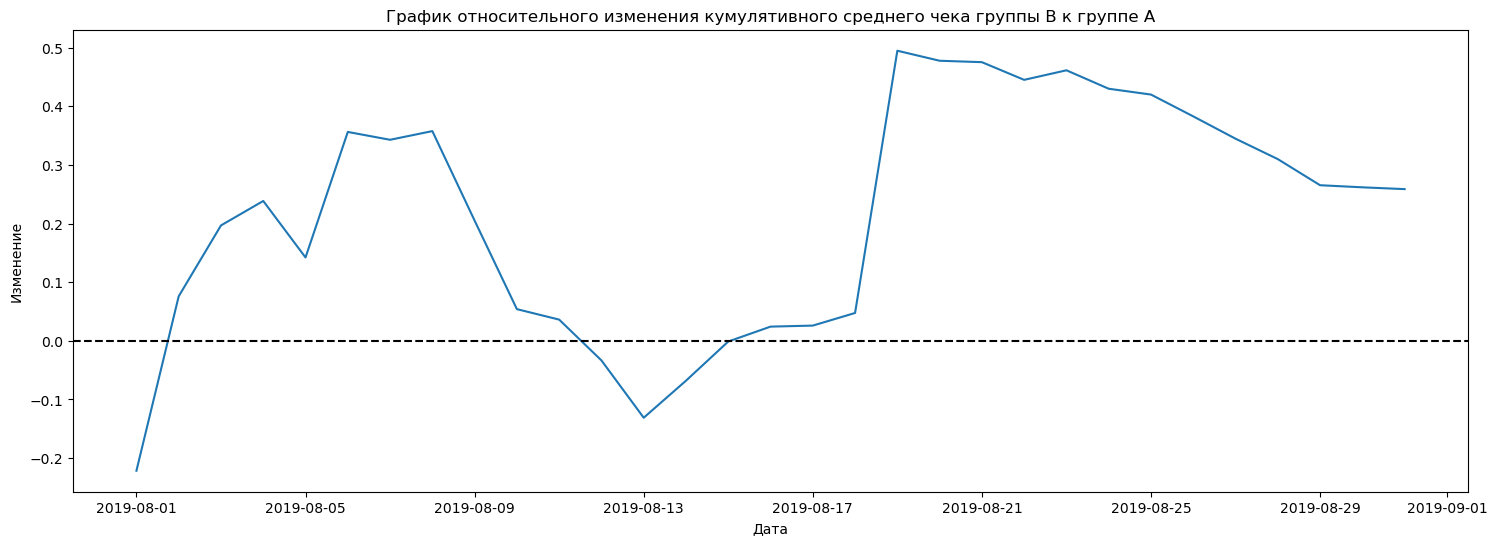

In [15]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.ylabel('Изменение')
plt.xlabel('Дата');

**Вывод:** в некоторые даты видны резкие и значительные изменения результатов. Скорее всего именно тогда и были совершены крупные заказы.

**Построим график кумулятивного среднего количества заказов на посетителя по группам.**

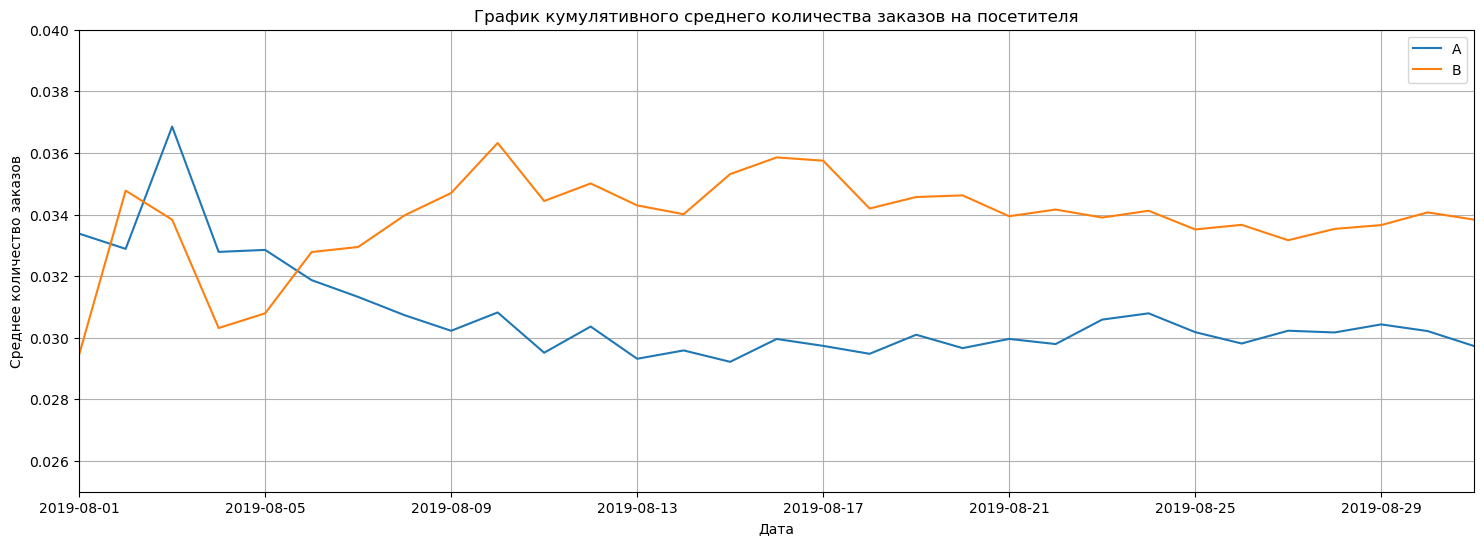

In [16]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.title('График кумулятивного среднего количества заказов на посетителя')
plt.grid(True)
# задаем масштаб осей
plt.axis(["2019-08-01", '2019-08-31', 0.025, 0.04])
plt.ylabel('Среднее количество заказов')
plt.xlabel('Дата');

**Вывод:** в начале теста количество заказов в группе А было больше, чем в группе В. После нескольких колебаний среднее количество заказов группы В превысило показатель группы А и установилось на уровне около 0.034, количество заказов группы А уменьшилось и установилось на уровне около 0.030.

**Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.**

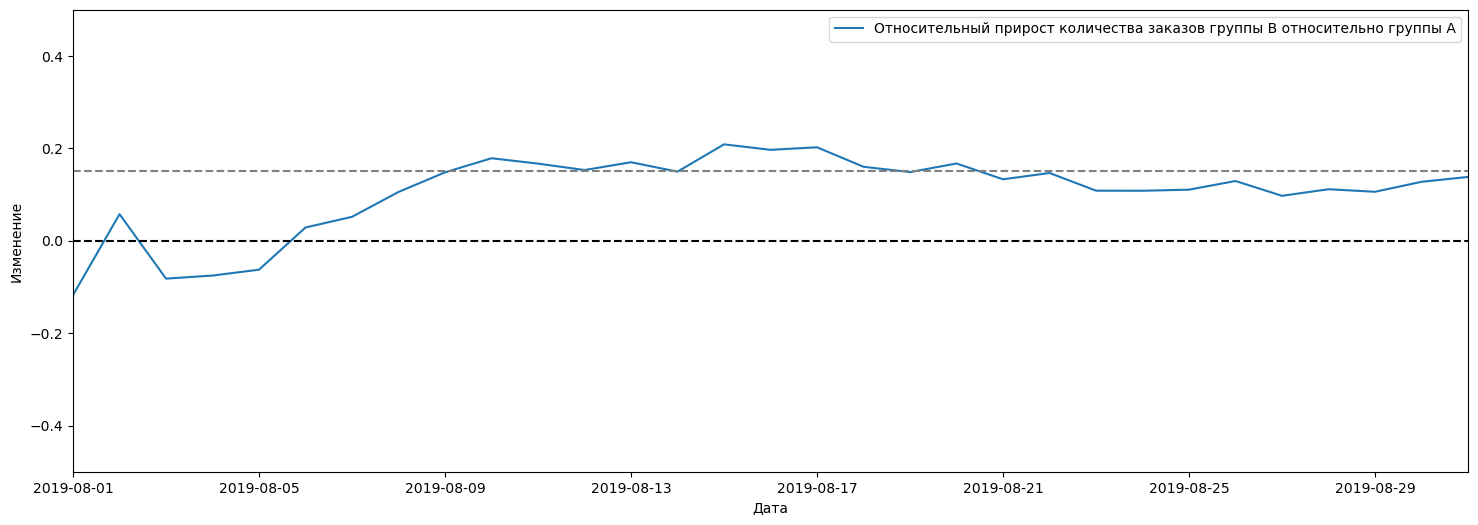

In [17]:
# Объединим таблицы с конверсиями
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост количества заказов группы B относительно группы A")
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--')
plt.axis(["2019-08-01", '2019-08-31', -0.5, 0.5])
plt.ylabel('Изменение')
plt.xlabel('Дата');

**Вывод:** вскоре после начала теста количество заказов группы В стало больше количества заказов группы А и оставалось таким на протяжении всего теста либо зафиксировалось около прироста в 15% относительно группы А.

**Построим точечный график количества заказов по пользователям.**

      visitor_id  orders
1023  4256040402      11
591   2458001652      11
569   2378935119       9
487   2038680547       8
44     199603092       5
744   3062433592       5
55     237748145       5
917   3803269165       5
299   1230306981       5
897   3717692402       5


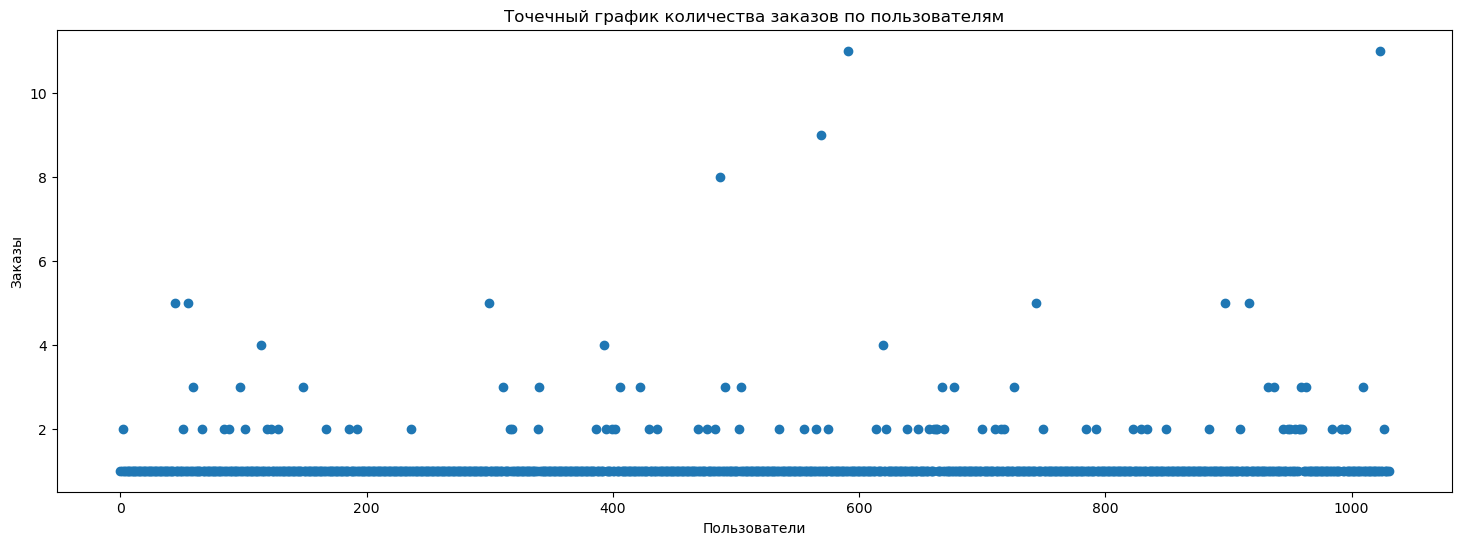

In [18]:
ordersByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
ordersByUsers.columns = ['visitor_id', 'orders']

print(ordersByUsers.sort_values(by='orders', ascending=False).head(10))

# серия из чисел от 0 до количества наблюдений в ordersByUsers
x_values = pd.Series(range(0, len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders'])
plt.ylabel('Заказы')
plt.xlabel('Пользователи')
plt.title('Точечный график количества заказов по пользователям');

**Вывод:** пользователей, заказавших более 2х раз очень мало. Скорее всего это можно считать выбросами.

**Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Выберем границу для определения аномальных пользователей.**

In [19]:
print(np.percentile(ordersByUsers['orders'], [95, 99]))

[2. 4.]


**Вывод:** не более 5% пользователей совершали больше двух заказов, не более 1% - более четырех заказов. Примем за аномальных пользователей тех, кто совершил больше 2 заказов.

**Построим точечный график стоимостей заказов.**

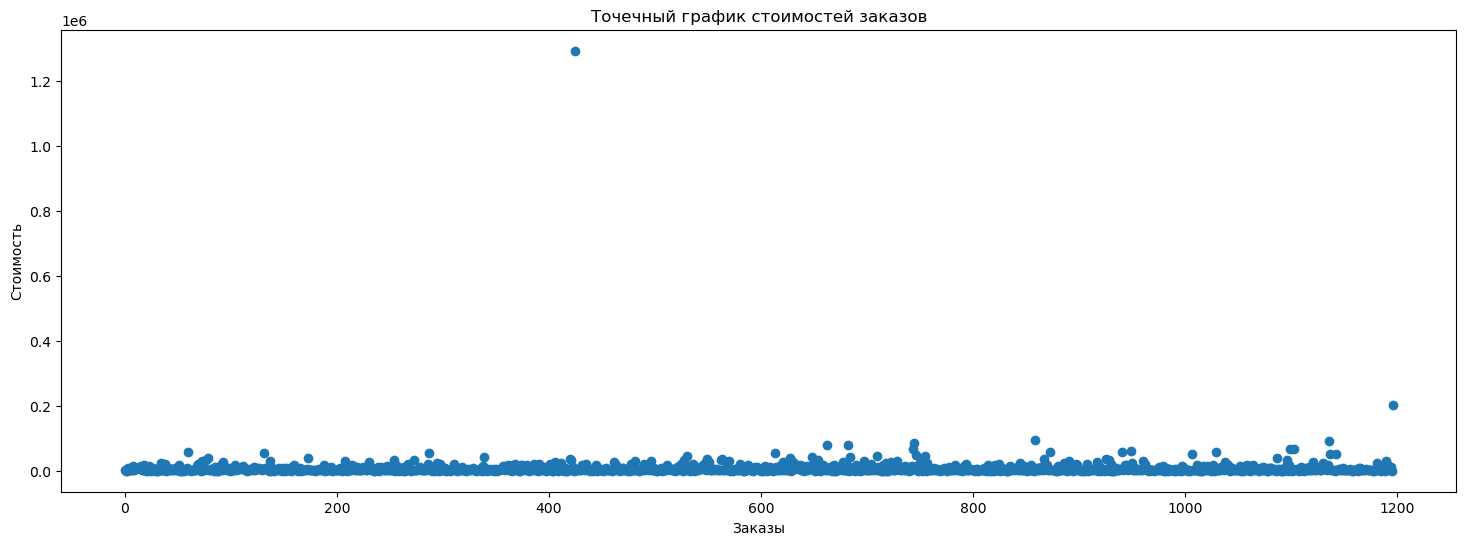

In [20]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.ylabel('Стоимость')
plt.xlabel('Заказы')
plt.title('Точечный график стоимостей заказов');

На графике виден аномально дорогой заказ выше 1,2 млн. Ограничим график по вертикальной оси для увеличения масштаба.

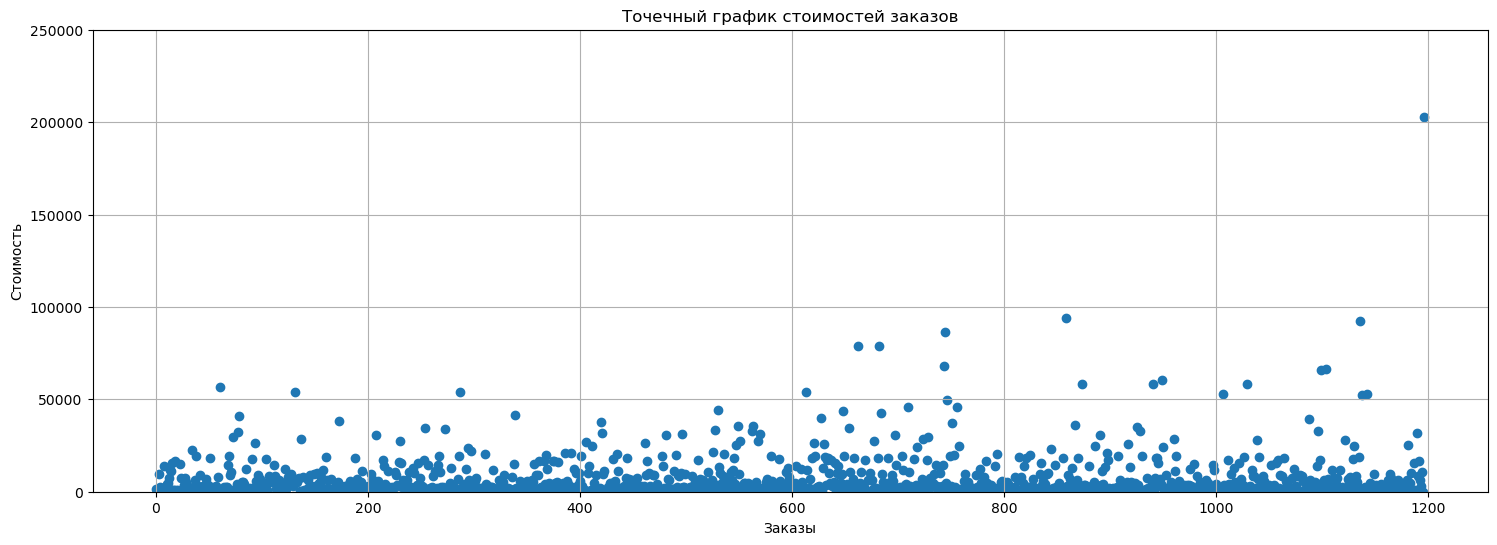

In [21]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.ylim(0, 250000)
plt.grid(True)
plt.ylabel('Стоимость')
plt.xlabel('Заказы')
plt.title('Точечный график стоимостей заказов');

**Вывод:** подавляющее большинство заказов находится ниже отметки 50 000.

**Посчитаем 95-й и 99-й перцентили стоимости заказов. Выберем границу для определения аномальных заказов.**

In [22]:
print(np.percentile(orders.revenue, [95, 99]))

[28000.  58233.2]


**Вывод:** не более чем у 5% заказов чек дороже 28 000 и не более чем у 1% заказов - чек дороже 58 233,20. Примем за аномально высокие, заказы дороже 28 000.

**Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным.**

Сформулируем гипотезы.\
Нулевая: различий в среднем количестве заказов между группами нет.\
Альтернативная: различия в среднем между группами есть.

In [23]:
# Установим уровень значимости
alpha = 0.05

visitsADaily = visits[visits['group'] == 'A'][['date', 'visitors']]
visitsADaily.columns = ['date', 'visitorsPerDateA']

visitsACummulative = visitsADaily.apply(
    lambda x: visitsADaily[visitsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitsACummulative.columns = ['date', 'visitorsCummulativeA']

visitsBDaily = visits[visits['group'] == 'B'][['date', 'visitors']]
visitsBDaily.columns = ['date', 'visitorsPerDateB']

visitsBCummulative = visitsBDaily.apply(
    lambda x: visitsBDaily[visitsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'visitor_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitsADaily, left_on='date', right_on='date', how='left')
    .merge(visitsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitsBCummulative, left_on='date', right_on='date', how='left')
)


ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitor_id', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitor_id', 'orders']

pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')
[ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')]
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

print("P-value: {0:.3f}".format(st.mannwhitneyu(sampleA, sampleB)[1]))



print("Прирост: {0:.3f}".format(sampleB.mean()/sampleA.mean()-1))

P-value: 0.017
Прирост: 0.138


**Вывод:** P-value меньше 0,05 (0.017<0.05), следовательно нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет отвергаем. Анализ "сырых данных" говорит о том, что в среднем количестве заказов между группами есть статистически значимые различия.\
Относительный прирост среднего количества заказов группы В к среднему группы А равен 13,8%.

**Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.**

Нулевая гипотеза: различий в среднем чеке между группами нет.\
Альтернативная гипотеза: различия в среднем чеке между группами есть. 

In [24]:
print('P-value: {0:.3f}'.format(st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Коэффициент различия: {0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

P-value: 0.729
Коэффициент различия: 0.259


**Вывод:** P-value больше 0,05 - статистически значимых различий в среднем чеке между группами нет, при этом относительное различие в среднем чеке почти 26%. Возможно имеет место наличие выбросов.

**Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.**

Сформулируем гипотезы.\
Нулевая: различий в среднем количестве заказов между группами по "очищенным данным"  нет.\
Альтернативная: различия в среднем между группами по "очищенным данным" есть.

In [25]:
# Очищаем данные от выбросов
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['visitor_id'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['visitor_id'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitor_id']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head())
print('Аномальных пользователей:', abnormalUsers.shape[0])

1099    148427295
18      199603092
928     204675465
23      237748145
37      249864742
Name: visitor_id, dtype: int64
Аномальных пользователей: 74


In [26]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)
print('P-value: {0:.3f}'.format(st.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

P-value: 0.013
0.173


**Вывод:** как и в случае с "сырыми" данными P-value меньше уровня статистической значимости (0,013<0.05), следовательно сегмент В лучше сегмента А. Относительный прирост среднего группы В к среднему количеству заказов группы А по очищенным данным равен 17,3%.

**Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.**

Нулевая гипотеза: различий в среднем чеке между группами по «очищенным» данным нет.\
Альтернативная гипотеза: различия в среднем чеке между группами по «очищенным» данным есть. 

In [27]:
print(
    'P-value: {0:.3f}'.format(
        st.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "Коэффициент различия: {0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

P-value: 0.738
Коэффициент различия: -0.020


**Вывод:** как и в случае с "сырыми" данными статистически значимых различий между группами после удаления аномалий нет (P-value>0.05). Относительное различие между группами всего 2%.

## Решение

В ходе анализа группа В показывала лучшие результаты по отношению группы А (кумулятивный средний чек, кумулятивное среднее количество заказов, кумулятивная выручка), но при этом смущали резкие скачки на графиках. После очистки данных сомнения подтвердились, т.к. разница между средними чеками значительно уменьшилась.\
Показатель среднего количества заказов в группе B как в случае с "сырыми" данными, так и после очистки, больше показателя в группе A (13.8% до, и 17.3% после).\
По результатам теста данная разница считается статистически значимой, следовательно можно сделать вывод о том, что можно остановить тест и зафиксировать победу группы В.